In [1]:
#opencv import
import cv2
import numpy as np
import time
import os
import sys
import math
import random
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlate2d
from scipy.optimize import minimize
import scipy.interpolate
from skimage.restoration import wiener
from numpy.linalg import lstsq
import skimage
from scipy.ndimage import convolve
import seaborn as sns
from scipy.fftpack import fft2, ifft2, fftshift
import concurrent.futures
from scipy.ndimage import shift as nd_shift
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter


Image size:  (605, 454)


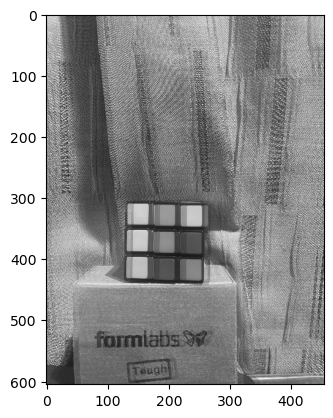

In [2]:
# image_path = "matlab/blueblack.jpeg"
image_path = "rubix/nopol.jpg"
# image_path = "matlab/flower.jpg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# read rgb
# original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# resize image to 30% of original size
original_image = cv2.resize(original_image, (0,0), fx=0.15, fy=0.15)
# get image size
height, width = original_image.shape[:2]
image_size = (height, width)
I1 = original_image.copy()
I2 = I1.copy()
print("Image size: ", image_size)
shift = 10
w1 = 0.3
w2 = 0.7

# I2[:,shift:] = I2[:,:-shift]
I2[:, :-shift] = I2[:, shift:]
# if not greyscale image go int
if len(I1.shape) > 2:
    It = (w1 * I1.astype(int) + w2 * I2.astype(int)).astype(int)
else:
    It = (w1 * I1 + w2 * I2)


# crop each edge by shift
# It = It[:, shift:-shift]

# show image
plt.imshow(It, cmap='gray')
plt.show()


In [3]:
def cross_correlation_channel_fft(It_channel, max_shift):
    shift_values = []
    correlation_values = []

    for x_shift in range(-max_shift, max_shift + 1):
        # Apply shift to the image channel along the x-axis
        It_channel_shifted = nd_shift(It_channel, shift=(0, x_shift), mode='constant', cval=0)

        # FFT of both original and shifted images
        f1 = fft2(It_channel)
        f2 = fft2(It_channel_shifted)

        # Compute cross-correlation
        cross_corr = np.real(ifft2(f1 * np.conj(f2)))
        cross_corr = fftshift(cross_corr)  # Center the zero-shift at the middle

        # Find the correlation value at the middle (zero shift)
        middle_idx = cross_corr.shape[1] // 2
        correlation_value = cross_corr[:, middle_idx].max()

        # Store the shift and its corresponding correlation value
        shift_values.append(x_shift)
        correlation_values.append(correlation_value)

    # Convert to numpy arrays for easier handling
    shift_values = np.array(shift_values)
    correlation_values = np.array(correlation_values)

    return shift_values, correlation_values

# It_r, It_g, It_b = It[:, :, 0], It[:, :, 1], It[:, :, 2]

# Process each channel sequentially
# cross_correlation_channel_fft(It_r)
# cross_correlation_channel_fft(It_g)
# cross_correlation_channel_fft(It_b)


# max_shift = half the width of the image
# max_shift = width // 2
max_shift = 25
shift, correlation = cross_correlation_channel_fft(It, max_shift)

In [4]:
def get_corr_peaks(shift, correlation):
    peaks = []
    steepness = []
    for i in range(len(shift)):
        # third condition is to ignore middle peak as that will always be largest
        if i == 0 or i == len(shift)-1 or i == (len(shift) - 1)/2:
            continue
        else:
            left_corr = correlation[i-1]
            right_corr = correlation[i+1]
            mid_corr = correlation[i]
            left_rise = mid_corr - left_corr
            right_rise = mid_corr - right_corr
            if left_rise > 0 and right_rise > 0:
                peaks.append(i)
                steepness.append(left_rise + right_rise)

    return peaks, steepness

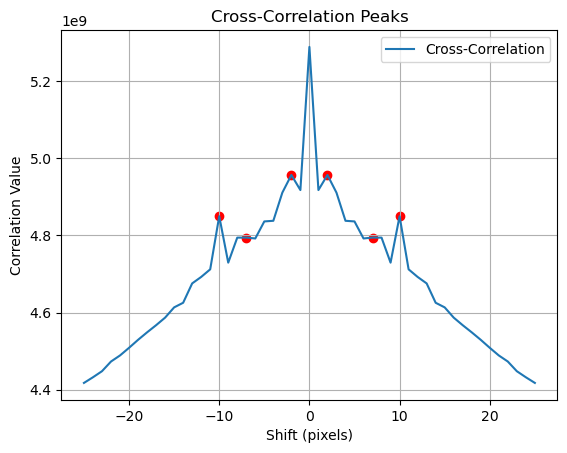

In [5]:
peaks, steepness = get_corr_peaks(shift, correlation)
# Plot the original data and highlight the peaks
plt.figure()
plt.plot(shift, correlation, label="Cross-Correlation")
for i in peaks:
    plt.scatter(shift[i], correlation[i], color='red')
plt.title("Cross-Correlation Peaks")
plt.xlabel("Shift (pixels)")
plt.ylabel("Correlation Value")
plt.grid(True)
plt.legend()
plt.show()

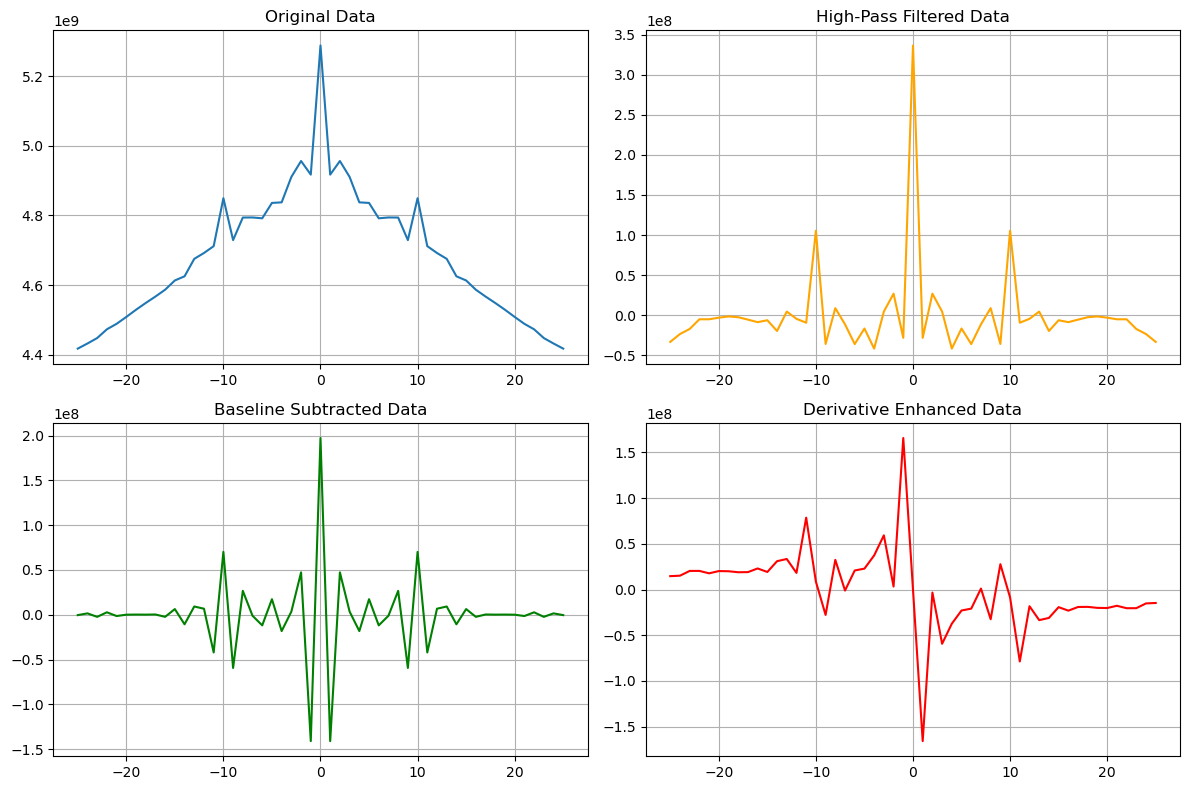

In [6]:
y = correlation
x = shift

sigma = 3 
y_smooth = gaussian_filter1d(y, sigma=sigma)
y_high_pass = y - y_smooth

#Subtracting a Smooth Baseline using Savitzky-Golay Filter
window_length = 5  
polyorder = 3 
y_baseline = savgol_filter(y, window_length, polyorder)
y_baseline_subtracted = y - y_baseline

# Derivative Enhancement
y_derivative = np.gradient(y, x)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(x, y, label="Original Data")
plt.title("Original Data")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(x, y_high_pass, label="High-Pass Filtered", color='orange')
plt.title("High-Pass Filtered Data")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(x, y_baseline_subtracted, label="Baseline Subtracted", color='green')
plt.title("Baseline Subtracted Data")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(x, y_derivative, label="Derivative", color='red')
plt.title("Derivative Enhanced Data")
plt.grid(True)

plt.tight_layout()
plt.show()


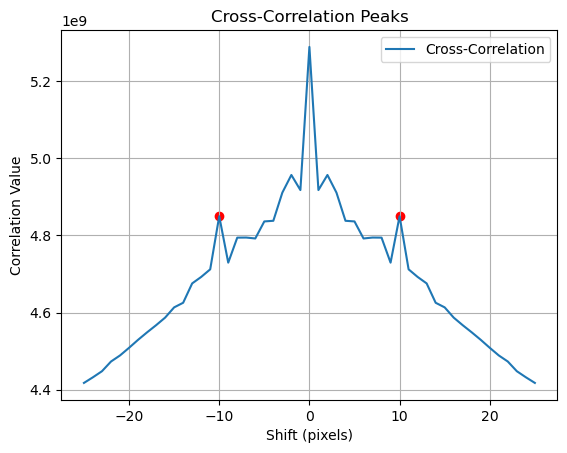

[-10, 10]


In [7]:
peaks, steepness = get_corr_peaks(shift, y_baseline_subtracted)

# sort peaks by steepness
sorted_peaks = [x for _, x in sorted(zip(steepness, peaks), reverse=True)]
# get top 2 peaks
top_peaks = sorted_peaks[:2]

# plot the top 2 peaks
plt.figure()
plt.plot(shift, correlation, label="Cross-Correlation")
for i in top_peaks:
    plt.scatter(shift[i], correlation[i], color='red')
plt.title("Cross-Correlation Peaks")
plt.xlabel("Shift (pixels)")
plt.ylabel("Correlation Value")
plt.grid(True)
plt.legend()
plt.show()
# get x value of top two peaks
top_peaks_x = [shift[i] for i in top_peaks]
print(top_peaks_x)
if abs(top_peaks_x[0]) == abs(top_peaks_x[1]):
    estimated_shift = top_peaks_x[0]

In [8]:

def estimate_weights_frequency_domain(It, shift):
    # Compute the Fourier Transform of the blended image
    F = fft2(It)
    F_shifted = fftshift(F)  #  zero frequency to the center

    #  frequency ranges for low and high frequencies
    rows, cols = It.shape
    crow, ccol = rows // 2, cols // 2
    # cutoffs
    low_freq_radius = min(crow, ccol) // 8 
    high_freq_radius = min(crow, ccol) // 2  

    # Create a mask for low frequencies
    low_freq_mask = np.zeros_like(F)
    high_freq_mask = np.zeros_like(F)
    for i in range(rows):
        for j in range(cols):
            dist = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
            if dist < low_freq_radius:
                low_freq_mask[i, j] = 1
            elif dist > high_freq_radius:
                high_freq_mask[i, j] = 1

    # Apply masks to the Fourier-transformed image
    low_freq_component = np.abs(F_shifted * low_freq_mask)
    high_freq_component = np.abs(F_shifted * high_freq_mask)

    # Calculate the sum of magnitudes in low and high frequency regions
    low_freq_sum = np.sum(low_freq_component)
    high_freq_sum = np.sum(high_freq_component)

    # Estimate the ratio R between high and low frequency contributions
    if low_freq_sum != 0:
        R = high_freq_sum / low_freq_sum
    else:
        R = np.nan  # Handle division by zero

    # Estimate w1 and w2 based on the ratio R
    if np.isfinite(R) and R > 0:
        w1_estimated = 1 / (1 + R)
        w2_estimated = R / (1 + R)
    else:
        w1_estimated = np.nan
        w2_estimated = np.nan

    return w1_estimated, w2_estimated


w1_estimated, w2_estimated = estimate_weights_frequency_domain(It, estimated_shift)
print("Estimated w1:", w1_estimated)
print("Estimated w2:", w2_estimated)

Estimated w1: 0.06200895027757889
Estimated w2: 0.9379910497224211


In [9]:
def create_psf(w1, w2, shift):
    psf = np.zeros(abs(shift))
    if shift < 0:
        psf[abs(shift) - 1] = w2
        psf[0] = w1
    else:
        psf[0] = w2
        psf[shift - 1] = w1

    # Normalize
    psf = psf / np.sum(psf)

    # Convert to 2D
    psf = np.expand_dims(psf, axis=0)
    
    return psf

def psf_test(psf, original_blurred, original):
    # Apply the point spread function to the original image
    blurred = convolve(original, psf, mode='constant', cval=0.0)

    # Display the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_blurred, cmap='gray')
    plt.title('Original Blurred Image')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title('New Blurred Image')

    # Calculate the difference between original_blurred and the new blurred image
    difference = np.abs(original_blurred.astype(float) - blurred.astype(float))
    print(np.max(difference))

    plt.subplot(1, 3, 3)
    sns.heatmap(difference, cmap='viridis', cbar=True, square=True)
    plt.title('Difference between Original blurred and Estimated blurred')
    plt.axis('off')  # Remove axis labels

    plt.show()

    return blurred
# ## rgb
# def psf_test(psf, original_blurred, original):
#     # Initialize an empty array for the new blurred image with the same shape as the original
#     blurred = np.zeros_like(original)

#     # Apply the point spread function to each channel of the RGB image
#     for i in range(3):  # Loop over the RGB channels
#         blurred[:, :, i] = convolve(original[:, :, i], psf, mode='constant', cval=0.0)

#     # Display the images
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 3, 1)
#     plt.imshow(original_blurred)
#     plt.title('Original Blurred Image')

#     plt.subplot(1, 3, 2)
#     plt.imshow(blurred)
#     plt.title('New Blurred Image')

#     # Calculate the difference between original_blurred and the new blurred image
#     difference = np.abs(original_blurred.astype(float) - blurred.astype(float))
#     print(np.max(difference))

#     difference_gray = np.mean(difference, axis=2)  # Convert difference to grayscale for heatmap
#     plt.subplot(1, 3, 3)
#     sns.heatmap(difference_gray, cmap='viridis', cbar=True, square=True)
#     plt.title('Difference between Original and Estimated blurred')
#     plt.axis('off')  # Remove axis labels

#     plt.show()

#     return blurred

In [10]:
def custom_wiener_deconvolution(blurred_image, psf, noise_variance=0):
    # Convert the PSF to the frequency domain
    psf_fft = fft2(psf, shape=blurred_image.shape)
    
    # Avoid division by zero in the deconvolution process
    psf_fft_abs2 = np.abs(psf_fft) ** 2
    psf_fft_abs2[psf_fft_abs2 < 1e-10] = 1e-10

    # Perform the Wiener filter manually
    wiener_filter = np.conj(psf_fft) / (psf_fft_abs2 + noise_variance)

    # Apply the Wiener filter to the blurred image in the frequency domain
    blurred_fft = fft2(blurred_image)
    deconvolved_fft = wiener_filter * blurred_fft

    # Convert back to the spatial domain
    estimated_image = np.real(ifft2(deconvolved_fft))

    return estimated_image

# ## rgb
# def custom_wiener_deconvolution(blurred_image, psf, noise_variance=0):
#     deconvolved_image = np.zeros_like(blurred_image)

#     # Loop over the RGB channels
#     for i in range(3):  # 
#         # Convert the PSF to the frequency domain
#         psf_fft = fft2(psf, shape=blurred_image[:, :, i].shape)
        
#         # Avoid division by zero in the deconvolution process
#         psf_fft_abs2 = np.abs(psf_fft) ** 2
#         psf_fft_abs2[psf_fft_abs2 < 1e-10] = 1e-10

#         # Perform the Wiener filter manually
#         wiener_filter = np.conj(psf_fft) / (psf_fft_abs2 + noise_variance)

#         # Apply the Wiener filter to the blurred image in the frequency domain
#         blurred_fft = fft2(blurred_image[:, :, i])
#         deconvolved_fft = wiener_filter * blurred_fft

#         # Convert back to the spatial domain and store in the result image
#         deconvolved_image[:, :, i] = np.real(ifft2(deconvolved_fft))

#     return deconvolved_image

242.09999999999997


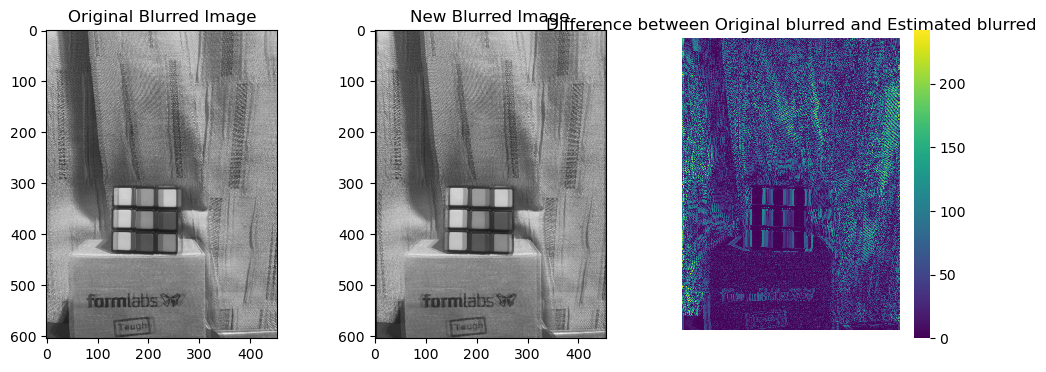

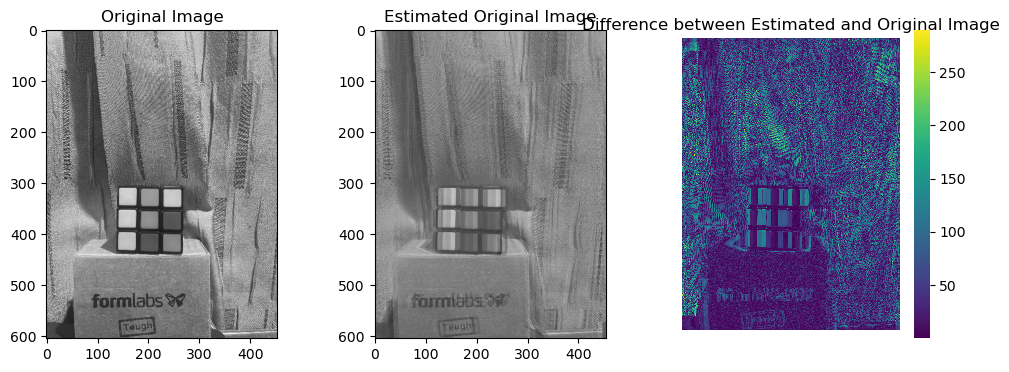

True

In [11]:
# estimated_shift = 10
# Create the point spread function
psf = create_psf(0.3,0.7, estimated_shift)

# Generate the blurred image
blurred = psf_test(psf, It, original_image)

# Perform Wiener deconvolution
estimated_original_image = custom_wiener_deconvolution(It, psf, 0.1)

# Display the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(estimated_original_image, cmap='gray')
plt.title('Estimated Original Image')

plt.subplot(1, 3, 3)
difference_image = np.abs(estimated_original_image - original_image)
sns.heatmap(difference_image, cmap='viridis', cbar=True, square=True)
plt.title('Difference between Estimated and Original Image')
plt.axis('off')  # Remove axis labels

# ## rgb
# # Convert the difference image to grayscale
# difference_image_gray = np.mean(np.abs(estimated_original_image - original_image), axis=2)


# plt.subplot(1, 3, 3)
# sns.heatmap(difference_image_gray, cmap='viridis', cbar=True, square=True)
# plt.title('Difference between Estimated and Original Image')
# plt.axis('off')  # Remove axis labels

plt.show()

# save estimate original
cv2.imwrite('rubix/estimated_original.jpg', estimated_original_image)

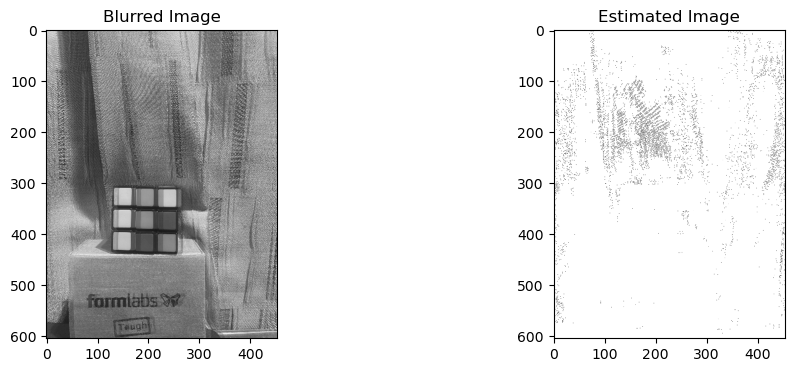

In [12]:
estimated_image = wiener(It, psf, 0)
# Display the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(It, cmap='gray')
plt.title('Blurred Image')

plt.subplot(1, 2, 2)
plt.imshow(estimated_image, cmap='gray')
plt.title('Estimated Image')
plt.show()